In [1]:
import pandas as pd
import pyomo.environ as pe
import pyomo.gdp as pyogdp
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from itertools import product

In [2]:
model = pe.ConcreteModel()
case_path = os.path.join(os.path.dirname(os.getcwd()), "data", "gantt2.csv")

In [3]:
df = pd.read_csv(case_path)
df['Scheduled in Room']=pd.to_datetime(df['Scheduled in Room'])
options = {"seconds": 60}

In [6]:
df['Primary Surgeon Name']

0                WARD III, JOHN F
1               ROUBAUD, MARGARET
2                  HWANG, ROSARIO
3                     JAVED, SABA
4                WARD III, JOHN F
5                WARD III, JOHN F
6                WARD III, JOHN F
7                  LIANG, DIANA H
8              DESNYDER, SARAH M.
9                WARD III, JOHN F
10                 LIANG, DIANA H
11               WARD III, JOHN F
12                  KUERER, HENRY
13    REFINETTI, ANA PAULA CORREA
14          MERIC-BERNSTAM, FUNDA
15    REFINETTI, ANA PAULA CORREA
16                 HWANG, ROSARIO
17          MERIC-BERNSTAM, FUNDA
18                BROWN, ERVIN B.
19                BROWN, ERVIN B.
20        FITZSULLIVAN, ELIZABETH
21                BROWN, ERVIN B.
22                BROWN, ERVIN B.
Name: Primary Surgeon Name, dtype: object

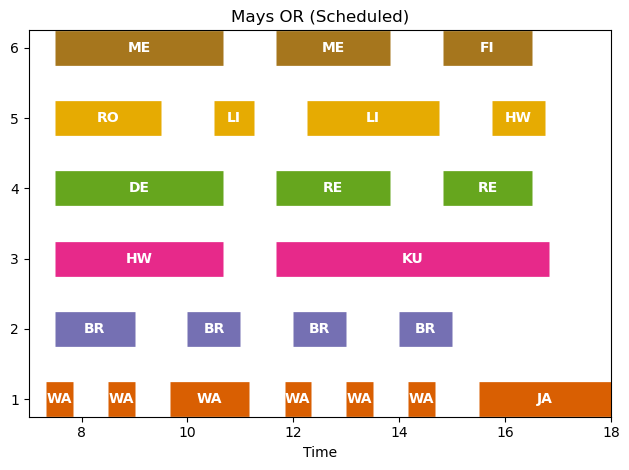

In [9]:
sessions = sorted(list(df['Room'].unique()))

bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
colors = cm.Dark2.colors

fig, ax = plt.subplots(1, 1)

for s_ix, s in df.iterrows():
    xs = s['Scheduled in Room'].hour + s['Scheduled in Room'].minute /60
    xf = s['Scheduled in Room'].hour + (s['Scheduled Room Duration'] + s['Scheduled in Room'].minute)/60
#     xf = s['Scheduled in Room'].hour + (s['Actual Room Duration'] + s['Scheduled in Room'].minute)/60
    ax.plot([xs, xf], [int(s['Room'][-2:])] * 2, c=colors[int(s['Room'][-2:])], **bar_style)
    ax.text((xs + xf) / 2, int(s['Room'][-2:]), s['Primary Surgeon Name'][:2], **text_style)

ax.set_title('Mays OR (Scheduled)')
# ax.set_title('Mays OR (Actual)')
ax.set_xlabel('Time')

ax.set_ylabel('')
# ax.grid(True)
ax.set_xlim([7, 18])

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()
plt.show()

In [15]:
class TheatreScheduler:
    def __init__(self, case_file_path, session_file_path):
        """
        Read case and session data into Pandas DataFrames
        Args:
            case_file_path (str): path to case data in CSV format
        """
        try:
            self.df_cases = pd.read_csv(case_file_path)
        except FileNotFoundError:
            print("Case data not found.")
        try:
            self.df_sessions = pd.read_csv(session_file_path)
        except FileNotFoundError:
            print("Session data not found")
        self.model = self.create_model()
    
    def _generate_case_durations(self):
        """
        Generate mapping of cases IDs to median case time for the procedure
        Returns:
            (dict): dictionary with CaseID as key and median case time (mins) for procedure as value
        """
        #return pd.Series(self.df_cases["Median Duration"].values, index=self.df_cases["CaseID"]).to_dict()
        return pd.Series(self.df_cases["Expected Duration"].values, index=self.df_cases["CaseID"]).to_dict()

    def _generate_session_durations(self):
        """
        Generate mapping of all theatre sessions IDs to session duration in minutes
        Returns:
            (dict): dictionary with SessionID as key and session duration as value
        """
        return pd.Series(self.df_sessions["Duration"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_session_start_times(self):
        """
        Generate mapping from SessionID to session start time
        Returns:
            (dict): dictionary with SessionID as key and start time in minutes since midnight as value
        """
        # Convert session start time from HH:MM:SS format into seconds elapsed since midnight
        self.df_sessions.loc[:, "Start"] = pd.to_timedelta(self.df_sessions["Start"])
        self.df_sessions.loc[:, "Start"] = self.df_sessions["Start"].dt.total_seconds() / 60
        return pd.Series(self.df_sessions["Start"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _get_ordinal_case_deadlines(self):
        """
        #TODO
        Returns:

        """
        self.df_cases.loc[:, "TargetDeadline"] = pd.to_datetime(self.df_cases["TargetDeadline"], format="%d/%m/%Y")
        self.df_cases.loc[:, "TargetDeadline"] = self.df_cases["TargetDeadline"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_cases["TargetDeadline"].values, index=self.df_cases["CaseID"]).to_dict()

    def _get_ordinal_session_dates(self):
        """
        #TODO
        Returns:

        """
        self.df_sessions.loc[:, "Date"] = pd.to_datetime(self.df_sessions["Date"], format="%d/%m/%Y")
        self.df_sessions.loc[:, "Date"] = self.df_sessions["Date"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_sessions["Date"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_disjunctions(self):
        """
        #TODO
        Returns:
            disjunctions (list): list of tuples containing disjunctions
        """
        cases = self.df_cases["CaseID"].to_list()
        sessions = self.df_sessions["SessionID"].to_list()
        disjunctions = []
        for (case1, case2, session) in product(cases, cases, sessions):
            if (case1 != case2) and (case2, case1, session) not in disjunctions:
                disjunctions.append((case1, case2, session))

        return disjunctions
    
    def create_model(self):
        model = pe.ConcreteModel()

        # Model Data

        # List of case IDs in surgical waiting list
        model.CASES = pe.Set(initialize=self.df_cases["CaseID"].tolist())
        # List of sessions IDs
        model.SESSIONS = pe.Set(initialize=self.df_sessions["SessionID"].tolist())
        # List of tasks - all possible (caseID, sessionID) combination
        model.TASKS = pe.Set(initialize=model.CASES * model.SESSIONS, dimen=2)
        # The duration (median case time) for each operation
        model.CASE_DURATION = pe.Param(model.CASES, initialize=self._generate_case_durations())
        # The duration of each theatre session
        model.SESSION_DURATION = pe.Param(model.SESSIONS, initialize=self._generate_session_durations())
        # The start time of each theatre session
        model.SESSION_START_TIME = pe.Param(model.SESSIONS, initialize=self._generate_session_start_times())
        # The deadline of each case
        model.CASE_DEADLINES = pe.Param(model.CASES, initialize=self._get_ordinal_case_deadlines())
        # The date of each theatre session
        model.SESSION_DATES = pe.Param(model.SESSIONS, initialize=self._get_ordinal_session_dates())


        model.DISJUNCTIONS = pe.Set(initialize=self._generate_disjunctions(), dimen=3)

        ub = 1440  # seconds in a day
        model.M = pe.Param(initialize=1e3*ub)  # big M
        max_util = 0.85
        num_cases = self.df_cases.shape[0]

        # Decision Variables
        model.SESSION_ASSIGNED = pe.Var(model.TASKS, domain=pe.Binary)
        model.CASE_START_TIME = pe.Var(model.TASKS, bounds=(0, ub), within=pe.PositiveReals)
        model.CASES_IN_SESSION = pe.Var(model.SESSIONS, bounds=(0, num_cases), within=pe.PositiveReals)

        # Objective
        def objective_function(model):
            return pe.summation(model.CASES_IN_SESSION)
            #return sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES for session in model.SESSIONS])
        model.OBJECTIVE = pe.Objective(rule=objective_function, sense=pe.maximize)

        # Constraints

        # Case start time must be after start time of assigned theatre session
        def case_start_time(model, case, session):
            return model.CASE_START_TIME[case, session] >= model.SESSION_START_TIME[session] - \
                   ((1 - model.SESSION_ASSIGNED[(case, session)])*model.M)
        model.CASE_START = pe.Constraint(model.TASKS, rule=case_start_time)

        # Case end time must be before end time of assigned theatre session
        def case_end_time(model, case, session):
            return model.CASE_START_TIME[case, session] + model.CASE_DURATION[case] <= model.SESSION_START_TIME[session] + \
                   model.SESSION_DURATION[session]*max_util + ((1 - model.SESSION_ASSIGNED[(case, session)]) * model.M)
        model.CASE_END_TIME = pe.Constraint(model.TASKS, rule=case_end_time)

        # Cases can be assigned to a maximum of one session
        def session_assignment(model, case):
            return sum([model.SESSION_ASSIGNED[(case, session)] for session in model.SESSIONS]) <= 1
        model.SESSION_ASSIGNMENT = pe.Constraint(model.CASES, rule=session_assignment)

        def set_deadline_condition(model, case, session):
            return model.SESSION_DATES[session] <= model.CASE_DEADLINES[case] + ((1 - model.SESSION_ASSIGNED[case, session])*model.M)
        model.APPLY_DEADLINE = pe.Constraint(model.TASKS, rule=set_deadline_condition)

        def no_case_overlap(model, case1, case2, session):
            return [model.CASE_START_TIME[case1, session] + model.CASE_DURATION[case1] <= model.CASE_START_TIME[case2, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M),
                    model.CASE_START_TIME[case2, session] + model.CASE_DURATION[case2] <= model.CASE_START_TIME[case1, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M)]

        model.DISJUNCTIONS_RULE = pyogdp.Disjunction(model.DISJUNCTIONS, rule=no_case_overlap)

        def theatre_util(model, session):
            return model.CASES_IN_SESSION[session] == \
                   sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES])

        model.THEATRE_UTIL = pe.Constraint(model.SESSIONS, rule=theatre_util)

        pe.TransformationFactory("gdp.bigm").apply_to(model)

        return model
    
    def solve(self, solver_name, options=None, solver_path=None, local=True):

        if solver_path is not None:
            solver = pe.SolverFactory(solver_name, executable=solver_path)
        else:
            solver = pe.SolverFactory(solver_name)

        # TODO remove - too similar to alstom
        if options is not None:
            for key, value in options.items():
                solver.options[key] = value

        if local:
            solver_results = solver.solve(self.model, tee=True, warmstart=True)
        else:
            solver_manager = pe.SolverManagerFactory("neos")
            solver_results = solver_manager.solve(self.model, opt=solver,  warmstart=True)

        results = [{"Case": case,
                    "Session": session,
                    "Session Date": self.model.SESSION_DATES[session],
                    "Case Deadline": self.model.CASE_DEADLINES[case],
                    "Days before deadline": self.model.CASE_DEADLINES[case] - self.model.SESSION_DATES[session],
                    "Start": self.model.CASE_START_TIME[case, session](),
                    "Assignment": self.model.SESSION_ASSIGNED[case, session]()}
                   for (case, session) in self.model.TASKS]

        self.df_times = pd.DataFrame(results)

        all_cases = self.model.CASES.value_list
        cases_assigned = []
        for (case, session) in self.model.SESSION_ASSIGNED:
            if self.model.SESSION_ASSIGNED[case, session] == 1:
                cases_assigned.append(case)

        cases_missed = list(set(all_cases).difference(cases_assigned))
        print("Number of cases assigned = {} out of {}:".format(len(cases_assigned), len(all_cases)))
        print("Cases assigned: ", cases_assigned)
        print("Number of cases missed = {} out of {}:".format(len(cases_missed), len(all_cases)))
        print("Cases missed: ", cases_missed)
        self.model.CASES_IN_SESSION.pprint()
        print("Total Objective = {}".format(sum(self.model.CASES_IN_SESSION.get_values().values())))
        print("Number of constraints = {}".format(solver_results["Problem"].__getitem__(0)["Number of constraints"]))
        #self.model.SESSION_ASSIGNED.pprint()
        print(self.df_times[self.df_times["Assignment"] == 1].to_string())
        self.draw_gantt()

    def draw_gantt(self):

        df = self.df_times[self.df_times["Assignment"] == 1]
        cases = sorted(list(df['Case'].unique()))
        sessions = sorted(list(df['Session'].unique()))

        bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
        text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
        colors = cm.Dark2.colors

        df.sort_values(by=['Case', 'Session'])
        df.set_index(['Case', 'Session'], inplace=True)

        fig, ax = plt.subplots(1, 1)
        for c_ix, c in enumerate(cases, 1):
            for s_ix, s in enumerate(sessions, 1):
                if (c, s) in df.index:
                    xs = df.loc[(c, s), 'Start'] /60
                    xf = (df.loc[(c, s), 'Start'] + self.df_cases[self.df_cases["CaseID"] == c]["Expected Duration"])/60
                    ax.plot([xs, xf], [s] * 2, c=colors[c_ix % 7], **bar_style)
                    ax.text((xs + xf) / 2, s, c, **text_style)

        ax.set_title('Assigning Ophthalmology Cases to Theatre Sessions')
        ax.set_xlabel('Time')
        ax.set_xlim([8.5, 18])
        ax.set_ylabel('Sessions')
        ax.grid(True)

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        fig.tight_layout()
        plt.show()

In [ ]:
# Import cases and sessions data into pyomo model
scheduler = TheatreScheduler(case_file_path=case_path, session_file_path=session_path)

In [ ]:
cbc_path = "C:\\Program Files\\Cbc-releases.2.10.8-w64-msvc16-md\\bin\\cbc.exe"
scheduler.solve(solver_name="cbc", solver_path=cbc_path, options=options)